In [304]:
import pandas as pd
import pingouin as pg
import numpy as np
import os, os.path as op

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('ggplot')

In [305]:
def get_estimates(model, long=True):
    est = model.conf_int().rename(columns={0:"LL",1:"UL"})
    est.insert(0,"coef", model.params)
    est = est.reset_index().rename(columns={"index":"variable"})
    
    return est


def plot_estimates(estimates=None, model=None, figsize=(12,8), boundaries=None, vline=True):

    def get_estimates(model, long=True):
        est = model.conf_int().rename(columns={0:"LL",1:"UL"})
        est.insert(0,"coef", model.params)
        est = est.reset_index().rename(columns={"index":"variable"})

        return est
    
    
    if estimates is None:
        estimates = get_estimates(model)
    
    fig, ax = plt.subplots(figsize=figsize)

    plt.errorbar(estimates['coef'], estimates.index, xerr=(estimates.UL - estimates.LL)/2, fmt='o', color='black',
                 ecolor=estimates.coef.apply(lambda c: '#E41A1C' if c < 0 else '#029E73'), elinewidth=3, capsize=0)

    plt.yticks(ticks=estimates.index,labels=estimates['variable'])

    if boundaries is not None:
        plt.xlim(boundaries[0],boundaries[1])
        
    if vline == True:
        plt.axvline(0,color='black',linewidth=2,alpha=.8,linestyle="--")
    

    plt.xlabel("Estimate")
    plt.ylabel("")
    plt.show()
    
    
def scale(data, mean=True, std=True):
    if mean == True & std == True:
        data = (data - data.mean()) / data.std()
    elif mean == True & std == False:
        data = data - data.mean()
    elif mean == False & std == True:
        data = data / data.std()
    return data

In [306]:
d = pd.read_csv(op.join(os.getcwd(),'alcohol','gapminder_alcohol.csv'))

In [307]:
d

,country,alcohol_consumption,income_per_person,suicide_per_100th,employ_rate,urban_rate,urbanization,employment
0,Afghanistan,0.03,NaN,6.684385,55.700001,24.04,<50,40-60
1,Albania,7.29,1914.996551,7.699330,51.400002,46.72,<50,40-60
2,Algeria,0.69,2231.993335,4.848770,50.500000,65.22,50-80,40-60
3,Andorra,10.17,21943.339900,5.362179,NaN,88.92,>80,NaN
4,Angola,5.57,1381.004268,14.554677,75.699997,56.70,50-80,>60
...,...,...,...,...,...,...,...,...
208,Vietnam,3.91,722.807559,11.653322,71.000000,27.84,<50,<40
209,West Bank and Gaza,NaN,NaN,NaN,32.000000,71.90,50-80,<40
210,Yemen. Rep.,0.20,610.357367,6.265789,39.000000,30.64,<50,<40
211,Zambia,3.56,432.226337,12.019036,61.000000,35.42,<50,<40


In [308]:
high_urban_rate = d['urbanization'] == '>80'
high_urban_rate_data = d[high_urban_rate]

medium_urban_rate = d['urbanization'] == '50-80'
medium_urban_rate_data = d[medium_urban_rate]

low_urban_rate = d['urbanization'] == '<50'
low_urban_rate_data = d[low_urban_rate]

## test t-Studenta dla prób niezależnych

#### Czy ludzie w państwach z poziomem urbanizacji pomiędzy 50-80% spożywają więcej alcoholu niż ludzie w państwach z poziomem urbanizacji poniżej 50%?

* H0: Ludzie w państwach z poziomem urbanizacji pomiędzy 50-80% nie spożywają więcej alcoholu niż ludzie w państwach z poziomem urbanizacji poniżej 50%.

* HA: Ludzie w państwach z poziomem urbanizacji pomiędzy 50-80% spożywają więcej alcoholu niż ludzie w państwach z poziomem urbanizacji poniżej 50%.

In [309]:
pg.ttest(medium_urban_rate_data['alcohol_consumption'], low_urban_rate_data['alcohol_consumption'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.09208,144.321492,two-sided,0.000071,"[1.63, 4.66]",0.661595,294.979,0.983427


In [310]:
d.groupby(['urbanization']).agg([np.mean, np.std]).round(2)

alcohol_consumption       income_per_person            \
                            mean   std              mean       std   
urbanization                                                         
50-80                       8.12  5.18           7274.64   9421.22   
<50                         4.98  4.31           6210.79  16776.38   
>80                         8.03  4.44          19690.02  12277.88   

             suicide_per_100th       employ_rate        urban_rate         
                          mean   std        mean    std       mean    std  
urbanization                                                               
50-80                     9.54  6.86       55.29   9.22      64.79   8.02  
<50                      10.46  6.33       62.81  11.10      37.72  20.83  
>80                       8.10  4.51       58.63   8.04      88.44   5.40

In [311]:
myColours = ['#4878d0', '#d65f5f', '#d5bb67', '#797979', '#dc7ec0', '#ee854a']

(0.0, 10.0)

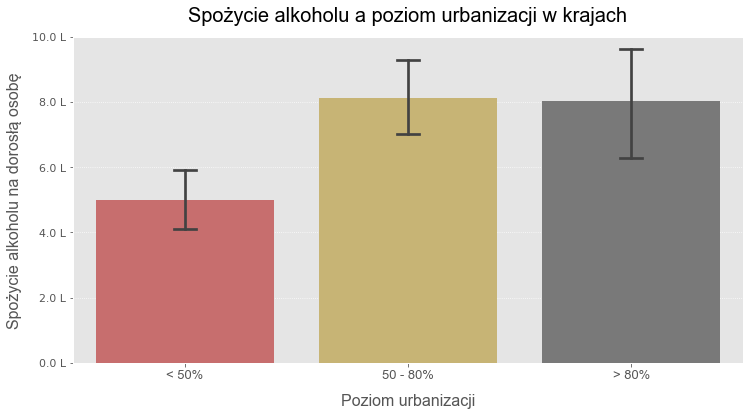

In [312]:
font_title = {'family': 'Arial',
       'size': 20}
font = {'family': 'Arial',
       'size': 16}
font_ticks = {'family': 'Arial',
       'size': 13}

fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(x='urbanization', y='alcohol_consumption',
            data=d, palette=myColours[1:5], capsize=.10)

ax.set_title('Spożycie alkoholu a poziom urbanizacji w krajach', fontdict=font_title, pad=15)

ax.set_ylabel('Spożycie alkoholu na dorosłą osobę', fontdict=font, labelpad=10)

ax.set_xlabel('Poziom urbanizacji', fontdict=font, labelpad=12)

ax.set_xticklabels(['< 50%', '50 - 80%', '> 80%'], fontdict=font_ticks)

ax.yaxis.set_major_formatter('{x} L')

ax.tick_params(axis='y', which='major', labelsize=11)

ax.grid(which='major', axis='y', ls=':')

ax.set_ylim(0, 10)

W celu sprawdzenia czy ludzie w państwach z poziomem urbanizacji pomiędzy 50-80% spożywają więcej alcoholu niż państwach z poziomem urbanizacji poniżej 50%, wykonano analizę t-Studenta dla prób niezależnych. Wynik analizy wykazał się istotny statystycznie, t(144) = 4.09 ; p < 0.001 ; d = 0.66. Wynik d Cohena wykazuje na występowanie średniego efektu. Spożycie alkoholu w państwach z poziomem urbanizacji pomiędzy 50-80% (M = 8.12 ; SD = 5.18) jest większe od spożycia alkoholu w państwach z poziomem urbanizacji poniżej 50% (M = 4.98 ; SD = 4.31).

## Jednoczynnikowa analiza wariancji (ANOVA) w schemacie międzygrupowym.

### Czy ilość spożycia alkoholu wpływa na stopę zatrudnienia?

* H0: Ilość spożycia alkoholu nie wpływa na stopę zatrudnienia.

* HA: Ilość spożycia alkoholu wpływa na stopę zatrudnienia.

In [313]:
high_employ_rate = d['employment'] == '>60'
high_employ_rate_data = d[high_employ_rate]

medium_employ_rate = d['employment'] == '40-60'
medium_employ_rate_data = d[medium_employ_rate]

low_employ_rate = d['employment'] == '<40'
low_employ_rate_data = d[low_employ_rate]

In [314]:
d.groupby(['employment']).agg([np.mean, np.std]).round(2)

alcohol_consumption       income_per_person            \
                          mean   std              mean       std   
employment                                                         
40-60                     8.36  5.25           8626.93  10657.13   
<40                       5.77  5.51           5840.86   9311.80   
>60                       5.50  3.88           7862.39  12011.81   

           suicide_per_100th       employ_rate        urban_rate         
                        mean   std        mean    std       mean    std  
employment                                                               
40-60                  11.53  7.75       55.32   3.38      60.38  19.49  
<40                     9.02  5.94       51.36  12.11      59.69  21.75  
>60                     9.19  5.10       68.24   6.63      50.30  26.84

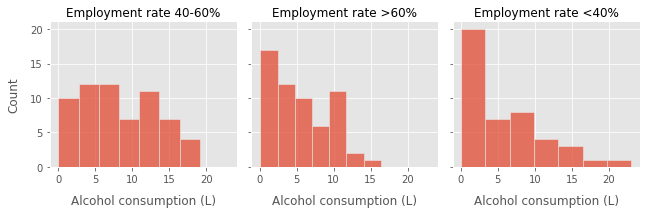

In [315]:
g = sns.FacetGrid(data=d, col='employment')

g.map_dataframe(sns.histplot, x='alcohol_consumption')
g.set_xlabels('Alcohol consumption (L)', labelpad=10)
g.set_ylabels('Count', labelpad=10)
g.set_titles(col_template="Employment rate {col_name}%")

In [316]:
pg.anova(data=d, dv='alcohol_consumption', between='employment').round(4)

,Source,ddof1,ddof2,F,p-unc,np2
0,employment,2,163,6.232,0.0025,0.071


F(2, 163) = 6.23 ; p = 0.002 ; etap2 = 0.07

In [317]:
pg.pairwise_ttests(data=d, dv='alcohol_consumption', between='employment', effsize='cohen', padjust='sidak').round(4)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,employment,40-60,<40,False,True,2.4435,89.7165,two-sided,0.0165,0.0487,sidak,2.857,0.4843
1,employment,40-60,>60,False,True,3.4422,114.0300,two-sided,0.0008,0.0024,sidak,35.012,0.6176
2,employment,<40,>60,False,True,0.2773,73.2683,two-sided,0.7823,0.9897,sidak,0.217,0.0580


In [318]:
d.groupby(['employment']).agg([np.mean, np.std]).round(2)

alcohol_consumption       income_per_person            \
                          mean   std              mean       std   
employment                                                         
40-60                     8.36  5.25           8626.93  10657.13   
<40                       5.77  5.51           5840.86   9311.80   
>60                       5.50  3.88           7862.39  12011.81   

           suicide_per_100th       employ_rate        urban_rate         
                        mean   std        mean    std       mean    std  
employment                                                               
40-60                  11.53  7.75       55.32   3.38      60.38  19.49  
<40                     9.02  5.94       51.36  12.11      59.69  21.75  
>60                     9.19  5.10       68.24   6.63      50.30  26.84

(0.0, 10.0)

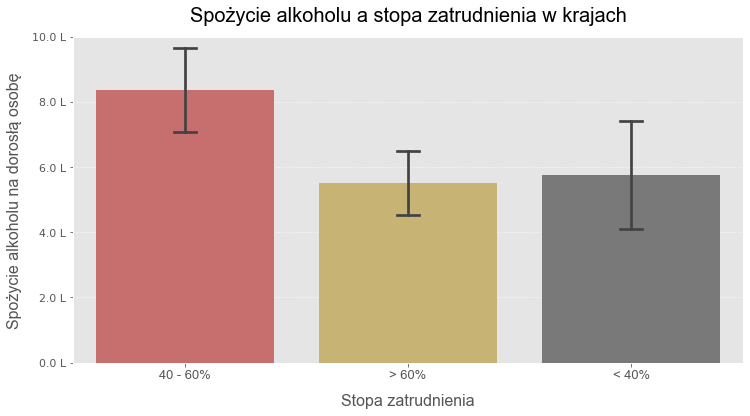

In [319]:
font_title = {'family': 'Arial',
       'size': 20}
font = {'family': 'Arial',
       'size': 16}
font_ticks = {'family': 'Arial',
       'size': 13}

fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(x='employment', y='alcohol_consumption',
            data=d, palette=myColours[1:5], capsize=.10)

ax.set_title('Spożycie alkoholu a stopa zatrudnienia w krajach', fontdict=font_title, pad=15)

ax.set_ylabel('Spożycie alkoholu na dorosłą osobę', fontdict=font, labelpad=10)

ax.set_xlabel('Stopa zatrudnienia', fontdict=font, labelpad=12)

ax.set_xticklabels(['40 - 60%', '> 60%', '< 40%'], fontdict=font_ticks)

ax.yaxis.set_major_formatter('{x} L')

ax.tick_params(axis='y', which='major', labelsize=11)

ax.grid(which='major', axis='y', ls=':')

ax.set_ylim(0, 10)

W celu sprawdzenia czy ilość spożycia alkoholu wpływa na stopień zatrudnienia, wykonano jednoczynnikową analizę wariancji w schemacie międzygrupowym. Wynik tej analizy okazał się istotny statystycznie, F(2, 163) = 6.23 ; p = 0.002 ; etap2 = 0.07. Wynik etap2 wykazuje na występowanie średniego efektu zatrudnienia. Porównania parami z korektą Sidaka wykazały istnienie istotnych statystycznie różnic między: 

- Państwami ze stopą zatrudnienia pomiędzy 40-60% a państwami ze stopą zatrudnienia poniżej 40% (p = 0.048),
- Państwami ze stopą zatrudnienia pomiędzy 40-60% a państwami ze stopą zatrudnienia powyżej 60% (p = 0.002).

Nie wykazano istotnych statystycznie różnic między państwami ze stopą zatrudnienia poniżej 40% a państwami ze stopą zatrudnienia powyżej 60% (p = 0.99).

Państwa ze stopą zatrudnienia pomiędzy 40-60% (M = 8.36 ; SD = 5.25) piją więcej alkoholu zarówno od państw ze stopą zatrudnienia poniżej 40% (M = 5.77 ; SD = 5.51), jak i od państw ze stopą zatrudnienia powyżej 60% (M = 5.50 ; SD = 3.88).

## Analiza korelacji

### Czy spożycie alkoholu jest powiązane z ilością samobójstw?

* H0: Spożycie alkoholu nie jest powiązane z ilością samobójstw.
* HA: Spożycie alkoholu jest powiązane z ilością samobójstw.

In [320]:
pg.corr(x=d['alcohol_consumption'], y=d['suicide_per_100th']).round(4)

,n,r,CI95%,p-val,BF10,power
pearson,185,0.3546,"[0.22, 0.47]",0.0,1.77e+04,0.9989


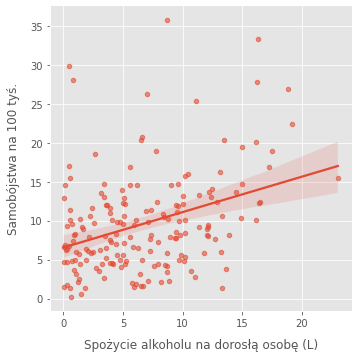

In [321]:
g = sns.lmplot(x='alcohol_consumption', y='suicide_per_100th', data=d, scatter_kws={'s':20, 'alpha':0.6})

g.set_xlabels('Spożycie alkoholu na dorosłą osobę (L)', labelpad=10)
g.set_ylabels('Samobójstwa na 100 tyś.', labelpad=10)

W celu sprawdzenia czy spożycie alkoholu  jest powiązane z ilością samobójstw wykonano analizę korelacji r Pearsona. Wynik analizy okazał się istotny statystycznie, r = 0.36 ; p < 0.001. Istnieje średnia, dodatnia korelacja pomiędzy zmiennymi. Interpretując uzyskany wynik analizy korelacji możemy powiedzieć, że ze wzrostem ilości spożytego alkoholu wzrasta szansa na popełnienie samobójstwa.

## Regresja liniowa

### Czy można przewidywać samobójstwa na postawie ilości spożytego alkoholu?

In [329]:
model = smf.ols('suicide_per_100th ~ alcohol_consumption', data=d).fit()
results = model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      suicide_per_100th   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     26.33
Date:                Mon, 10 Jan 2022   Prob (F-statistic):           7.32e-07
Time:                        17:55:00   Log-Likelihood:                -590.18
No. Observations:                 185   AIC:                             1184.
Df Residuals:                     183   BIC:                             1191.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.5503      0.736      8.903      0.000       5.099       8.002
alcohol_consumption     0.4554      0.089      5.131      0.000       0.280       0.631
==============================================================================
Omnibus:                       60.685   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.636
Skew:                           1.441   Prob(JB):                     8.74e-33
Kurtosis:                       6.293   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [323]:
def F(model, rnd= 2, prnd= 3):
    p = model2.f_pvalue
    pFillIn = f'< 0.001' if p < 0.001 else f'= {np.around(p, prnd)}'
    return f'F({int(model.df_model)}, {int(model.df_resid)}) = {np.around(model.fvalue, rnd)} ; p {pFillIn}'

F(model)

'F(1, 183) = 26.33 ; p < 0.001'

(-5.0, 25.0)

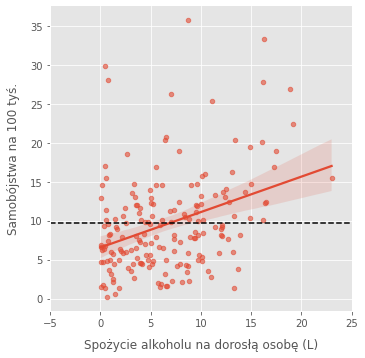

In [324]:
g2 = sns.lmplot(x='alcohol_consumption', y='suicide_per_100th', data=d, scatter_kws={'s':20, 'alpha':0.6})
plt.hlines(y=d['suicide_per_100th'].mean(), xmin=-5, xmax=25, color='black', linestyles='dashed')

g2.set_xlabels('Spożycie alkoholu na dorosłą osobę (L)', labelpad=10)
g2.set_ylabels('Samobójstwa na 100 tyś.', labelpad=10)

plt.xlim(-5,25)

W celu sprawdzenia czy można przywidywać ilość samobójstw na podstawie ilości spożytego alkoholu, wykonano analizę regresji liniowej. Proponowany model pozwala na przywidywanie ilości samobójstw na podstawie ilości spożytego alkoholu, F(1, 183) = 26.33 ; p = < 0.001. Równanie regresji możemy zapisać za pomocą wzoru: 

* Ilość samobójstw = 6.55 + 0.46 * Ilość spożytego alkoholu.

Ten model wyjaśnia 12.6% wariancji samobójstw. Samobójstwa są średnie powiązane z ilością spożytego alkoholu (r = 0.36 ; p < 0.001). Analiza regresji liniowej potwierdza wynik uzyskany przy przeprowadzeniu analizy korelacji.

## Regresja wielozmiennowa

### Czy można przywidywać samobójstwa na podstawie ilości spożytego alkoholu oraz poziomu urbanizacji?

In [325]:
model2 = smf.ols('scale(suicide_per_100th) ~ scale(alcohol_consumption) + urbanization', data=d).fit()
results2 = model2.summary()
results2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     scale(suicide_per_100th)   R-squared:                       0.173
Model:                                  OLS   Adj. R-squared:                  0.159
Method:                       Least Squares   F-statistic:                     12.36
Date:                      Mon, 10 Jan 2022   Prob (F-statistic):           2.23e-07
Time:                              17:54:39   Log-Likelihood:                -240.07
No. Observations:                       181   AIC:                             488.1
Df Residuals:                           177   BIC:                             500.9
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.1235      0.108     -1.138      0.256      -0.338       0.091
urbanization[T.<50]            0.3782      0.156      2.421      0.017       0.070       0.686
urbanization[T.>80]           -0.2239      0.204     -1.097      0.274      -0.627       0.179
scale(alcohol_consumption)     0.4210      0.072      5.859      0.000       0.279       0.563
==============================================================================
Omnibus:                       53.168   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.869
Skew:                           1.317   Prob(JB):                     1.54e-26
Kurtosis:                       5.971   Cond. No.                         3.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [326]:
def F2(model2, rnd= 2, prnd= 3):
    p2 = model2.f_pvalue
    p2FillIn = f'< 0.001' if p2 < 0.001 else f'= {np.around(p2, prnd)}'
    return f'F({int(model2.df_model)}, {int(model2.df_resid)}) = {np.around(model2.fvalue, rnd)} ; p {p2FillIn}'

F2(model2)

'F(3, 177) = 12.36 ; p < 0.001'

In [327]:
get_estimates(model2)

,variable,coef,LL,UL
0,Intercept,-0.123511,-0.337616,0.090593
1,urbanization[T.<50],0.378164,0.069850,0.686477
2,urbanization[T.>80],-0.223856,-0.626740,0.179027
3,scale(alcohol_consumption),0.421030,0.279207,0.562852


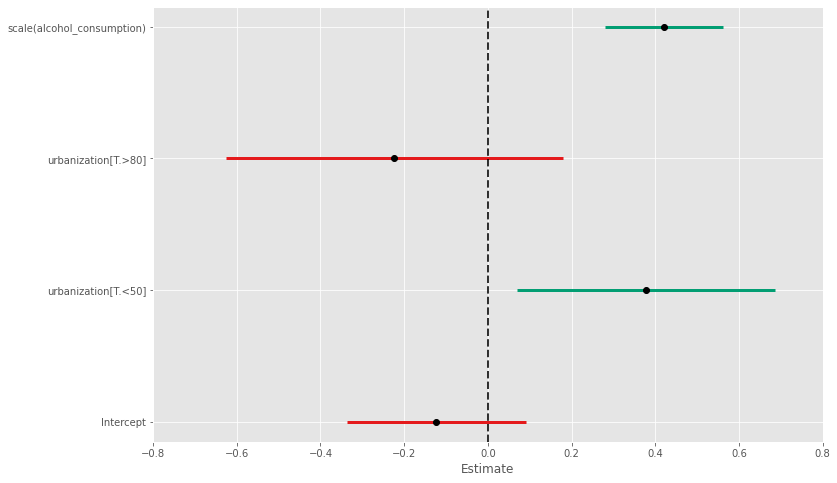

In [328]:
plot_estimates(model=model2, boundaries=(-0.8,0.8))

W celu sprawdzenia czy można przywidywać samobójstwa na podstawie ilości spożycia alkoholu oraz poziomu urbanizacji, wykonano analizę wielozmiennowej regresji. Proponowany model okazał się dobrze dopasowany do danych, F(3, 177) = 12.36 ; p < 0.001. Ten model przywiduje 15.9% wariancji samobójstw. Równanie regresji możemy zapisać za pomocą wzoru: 

* Samobójstwo = -0.1235 + 0.3782 * Poziom urbanizacji[<50%] - 0.2239 * Poziom urbanizacji[>80%] + 0.4210 * Spożycie alkoholu.

Interpretując uzyskane wyniki możemy powiedzieć, że im więcej osoba spożywa alkoholu tym większa szansa, że popełni samobójstwo. Szansa się zwiększa, jeśli osoba mieszka w kraju, gdzie poziom urbanizacji jest mniejszy od 50%.